# Genetic programming
Genetic programming (**GP**) are class of a evolutionary computing metaheuristic where solution is encoded into tree like structue [1].

**GP** algorithms follows the evolutionary scheme:
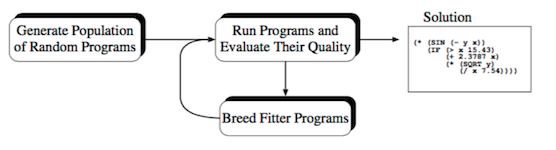

Solution is encoded into tree like structure:
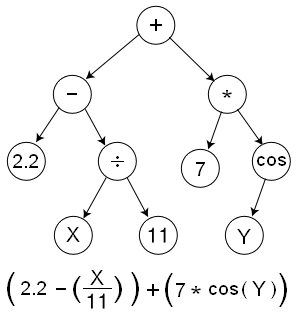


[1]: https://en.wikipedia.org/wiki/Genetic_programming

### Distributed Evolutionary Algorithms in Python (DEAP) [2]
DEAP is a novel evolutionary computation framework for rapid prototyping and testing of ideas. It seeks to make algorithms explicit and data structures transparent. It works in perfect harmony with parallelisation mechanism such as multiprocessing and SCOOP  |  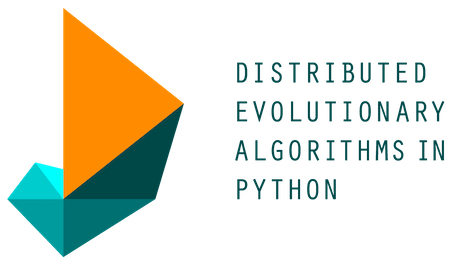  |  


[2]: http://deap.readthedocs.io/ 

### Evolutionary learning spam detection rules

File 'spambase.csv' contains 4600 email described with using 57 features. The last column of 'spambase.csv' denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. Most of the attributes indicate whether a particular word or character was frequently occuring in the e-mail. The run-length attributes (55-57) measure the length of sequences of consecutive capital letters. For the statistical measures of each attribute, see the end of this file. Here are the definitions of the attributes: 

48 continuous real [0,100] attributes of type word_freq_WORD 
= percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string. 

6 continuous real [0,100] attributes of type char_freq_CHAR] 
= percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail 

1 continuous real [1,...] attribute of type capital_run_length_average 
= average length of uninterrupted sequences of capital letters 

1 continuous integer [1,...] attribute of type capital_run_length_longest 
= length of longest uninterrupted sequence of capital letters 

1 continuous integer [1,...] attribute of type capital_run_length_total 
= sum of length of uninterrupted sequences of capital letters 
= total number of capital letters in the e-mail 

1 nominal {0,1} class attribute of type spam 
= denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail.

Features of each email:
```
1, 0.    | spam, non-spam classes

word_freq_make:         continuous.
word_freq_address:      continuous.
word_freq_all:          continuous.
word_freq_3d:           continuous.
word_freq_our:          continuous.
word_freq_over:         continuous.
word_freq_remove:       continuous.
word_freq_internet:     continuous.
word_freq_order:        continuous.
word_freq_mail:         continuous.
word_freq_receive:      continuous.
word_freq_will:         continuous.
word_freq_people:       continuous.
word_freq_report:       continuous.
word_freq_addresses:    continuous.
word_freq_free:         continuous.
word_freq_business:     continuous.
word_freq_email:        continuous.
word_freq_you:          continuous.
word_freq_credit:       continuous.
word_freq_your:         continuous.
word_freq_font:         continuous.
word_freq_000:          continuous.
word_freq_money:        continuous.
word_freq_hp:           continuous.
word_freq_hpl:          continuous.
word_freq_george:       continuous.
word_freq_650:          continuous.
word_freq_lab:          continuous.
word_freq_labs:         continuous.
word_freq_telnet:       continuous.
word_freq_857:          continuous.
word_freq_data:         continuous.
word_freq_415:          continuous.
word_freq_85:           continuous.
word_freq_technology:   continuous.
word_freq_1999:         continuous.
word_freq_parts:        continuous.
word_freq_pm:           continuous.
word_freq_direct:       continuous.
word_freq_cs:           continuous.
word_freq_meeting:      continuous.
word_freq_original:     continuous.
word_freq_project:      continuous.
word_freq_re:           continuous.
word_freq_edu:          continuous.
word_freq_table:        continuous.
word_freq_conference:   continuous.
char_freq_;:            continuous.
char_freq_(:            continuous.
char_freq_[:            continuous.
char_freq_!:            continuous.
char_freq_$:            continuous.
char_freq_#:            continuous.
capital_run_length_average: continuous.
capital_run_length_longest: continuous.
capital_run_length_total:   continuous
```

In [89]:
import warnings
warnings.simplefilter("ignore")

import operator
import itertools

from deap import algorithms, base, creator, tools, gp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("spambase.csv")
data = np.array(df)
emails=data[:,:-1]
targets=data[:,-1]

from sklearn.model_selection import train_test_split
emails_train, emails_test, targets_train, targets_test = train_test_split(emails, targets, test_size=0.33)

print("Train dataset shape: ", emails_train.shape)
print("Test dataset shape: ", emails_test.shape)

Train dataset shape:  (3082, 57)
Test dataset shape:  (1518, 57)


In [90]:
print("Class distributions: {:.2} in dataset".format(np.sum(targets)/len(targets)))

Class distributions: 0.39 in dataset


In [91]:
# defined a new primitive set for strongly typed GP
pset = gp.PrimitiveSetTyped("MAIN", itertools.repeat(float, 57), bool, "IN")

# boolean operators
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)

# logic operators
# Define a new if-then-else function
def if_then_else(input, output1, output2):
    if input:
        return output1
    else:
        return output2

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

pset.addTerminal(False, bool)
pset.addTerminal(True, bool)

In [92]:
# solution encoding 

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [93]:
#fit function

def evalSpambase(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    result = sum(bool(func(*mail)) is bool(target) for mail, target in zip(emails_train, targets_train))
    return result,

In [94]:
# GP parameters

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSpambase)

toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [95]:
# set population size
pop = toolbox.population(n=10)
hof = tools.HallOfFame(1)

history = tools.Statistics(lambda ind: ind.fitness.values)
history.register("max_fit", np.max)
history.register("mean_fit", np.mean)

pop, history = algorithms.eaSimple(pop, toolbox, 0.5, 0.2, 50, history, halloffame=hof)

print("Learned spam detection rule: ", hof[-1])

gen	nevals	max_fit	mean_fit
0  	10    	1853   	1577.3  
1  	8     	1853   	1851    
2  	4     	1853   	1759    
3  	8     	1853   	1853    
4  	5     	1853   	1853    
5  	8     	2259   	1893.6  
6  	5     	1853   	1786.1  
7  	5     	2011   	1868.8  
8  	4     	2011   	1916.2  
9  	5     	2011   	1947.8  
10 	2     	2130   	2013.5  
11 	8     	2130   	2030.5  
12 	6     	2130   	2116.7  
13 	7     	2396   	2106.3  
14 	5     	2340   	2142.3  
15 	10    	2130   	1984.3  
16 	6     	2371   	2120.2  
17 	5     	2371   	2119.3  
18 	7     	2371   	2208.8  
19 	6     	2371   	2340.6  
20 	5     	2371   	2265.9  
21 	3     	2371   	2268.7  
22 	4     	2371   	2319    
23 	8     	2371   	2295.8  
24 	4     	2371   	2200.6  
25 	6     	2396   	2306.5  
26 	5     	2396   	2300.8  
27 	8     	2396   	2265.1  
28 	6     	2396   	2286.1  
29 	9     	2396   	2240.3  
30 	8     	2396   	2285.5  
31 	4     	2395   	2386.2  
32 	4     	2395   	2345.4  
33 	6     	2396   	2356.4  
34 	6     	2396   	2

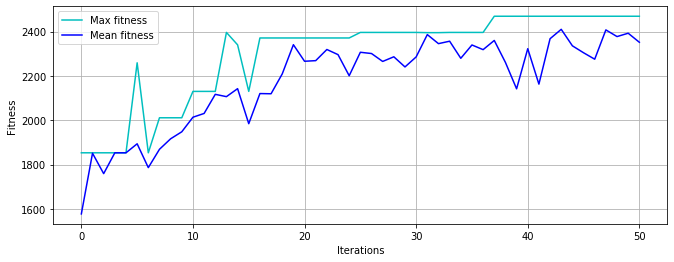

In [96]:
plt.figure(figsize=(11, 4))
plots = plt.plot(history.select('max_fit'),'c-', history.select('mean_fit'), 'b-')
plt.legend(plots, ('Max fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations'); plt.grid()

In [97]:
# # visualizing learned rule
# nodes, edges, labels = gp.graph(hof[-1])
# import networkx as nx
# from networkx.drawing.nx_agraph import graphviz_layout

# g = nx.Graph()
# g.add_nodes_from(nodes)
# g.add_edges_from(edges)

# pos = graphviz_layout(g, prog="dot")

# nx.draw_networkx_nodes(g, pos)
# nx.draw_networkx_edges(g, pos)
# nx.draw_networkx_labels(g, pos, labels)

In [100]:
# TODO: evaluate learned model with confusion matrix (using sklearn library)
# and compare result with other model (eg. NeuralNetwork, Logistic Regression)


# def predict(learned_model, mail):
#    ...
#    return 1 | 0

# iterate over all mails in test sets and classify them as either spam "1" or not "0"
# using sklearn.metrics module evaluate solution model using confusion_matrix


from sklearn.metrics import confusion_matrix as cm
from sklearn.linear_model import LogisticRegression


def predict(learned_model, mail):
    result = learned_model(*mail)
    if( result ):
        return 1
    else:
        return 0

    
    
    

gpc = gp.compile(hof[0], pset)

results = [];

for mail in emails:
    results.append( predict( gpc, mail) )
    
print("GP")
print(cm(targets, results))


logistic_regression = LogisticRegression()
logistic_regression.fit(emails, targets)

results = logistic_regression.predict(emails);

print("LR")
print(cm(targets, results))


GP
[[2638  150]
 [ 775 1037]]
LR
[[2665  123]
 [ 191 1621]]


### Evolutionary learning symbolic regression [3]

[3]: https://en.wikipedia.org/wiki/Symbolic_regression

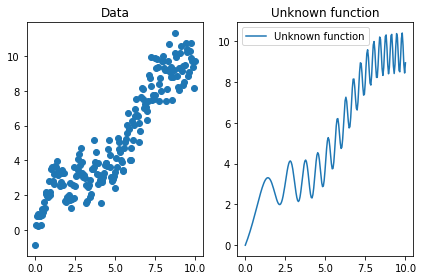

In [101]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(100)

def unknown_function(x):
#    return np.sin(x)*x
    return np.sin(x)+x+np.sin(x**2)

sample_number = 200
data = np.linspace(0, 10, sample_number)
target =  unknown_function(data)+ np.random.normal(0,0.5,sample_number)

plt.subplot('121')
plt.scatter(data, target)
plt.title('Data')
plt.subplot('122')
plt.plot(data, unknown_function(data), label='Unknown function')
plt.title('Unknown function')
plt.legend()
plt.tight_layout()

In [102]:
"""import operator

import random

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
"""
import math

def evalSymbReg(ind, context):
    f = context.compile(expr=ind)
    errors = ((f(d)-t)**2 for d,t in zip(data,target))
    return math.fsum(errors) / sample_number,

def genetic_programming(params={'population':200, 'iteration':100, 'verbose':False}):
    pset = gp.PrimitiveSet("MAIN", 1)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)
    pset.renameArguments(ARG0='x')

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    toolbox.register("evaluate", evalSymbReg, context=toolbox)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

    pop = toolbox.population(n=params['population'])
    hof = tools.HallOfFame(1)

    stats_fit = tools.Statistics(key=operator.attrgetter("fitness.values"))
    stats_fit.register("avg", np.mean)
    stats_fit.register("min", np.min)

    pop, history, = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, params['iteration'], stats=stats_fit, halloffame=hof, verbose=params['verbose'])
    
    return pop, history, hof, toolbox

pop, history, hof, context = genetic_programming({'population':50, 'iteration':50, 'verbose':False})
print("Learned function: " + str(hof[-1]))

Learned function: add(sin(mul(x, x)), x)


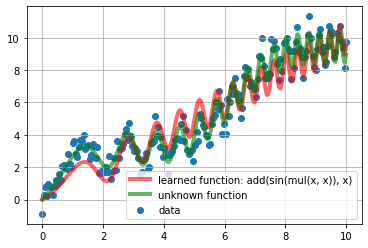

In [103]:
learned_function = context.compile(expr=hof[0])
learned_targets=[learned_function(point) for point in data]
plt.scatter(data, target, label='data')
plt.plot(data, learned_targets, c='red', lw=4, alpha=0.6, label='learned function: ' + str(hof[0]))
plt.plot(data, unknown_function(data), c='green', lw=4, alpha=0.6, label='unknown function')
plt.grid()
plt.legend()

## Additional reading:
1. [Intuitive introduction to DEAP](https://github.com/lmarti/evolutionary-computation-course/blob/master/AEC.02%20-%20Elements%20of%20Evolutionary%20Algorithms.ipynb)

2. [Solving the TSP with GA](https://github.com/lmarti/evolutionary-computation-course/blob/master/AEC.03%20-%20Solving%20the%20TSP%20with%20GAs.ipynb)

# Appendix

To install DEAP framework using conda:
`conda install -c conda-forge deap`